## An exploration of daily US birth data suggests that the number of births that occurs on any given day is far from random.  In addition to the variation seen across the months of the year and days of the week, the number of daily births appears to be greatly influenced by holidays and perhaps even superstition. 

### First, import the requisite libraries and other housekeeping tasks.

In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import calendar
plt.style.use('fivethirtyeight')
%matplotlib inline

### Load the csv file into a pandas dataframe.  Daily US birth data courtesy of [fivethirtyeight](https://github.com/fivethirtyeight/data/blob/master/births/US_births_2000-2014_SSA.csv).

In [2]:
data = pd.read_csv('data/birth_data.csv')
data.head()

,year,month,date_of_month,day_of_week,births
0,2000,1,1,6,9083
1,2000,1,2,7,8006
2,2000,1,3,1,11363
3,2000,1,4,2,13032
4,2000,1,5,3,12558


### The histogram of the number of daily US births has a bimodal distribution.  Any guesses as to why?

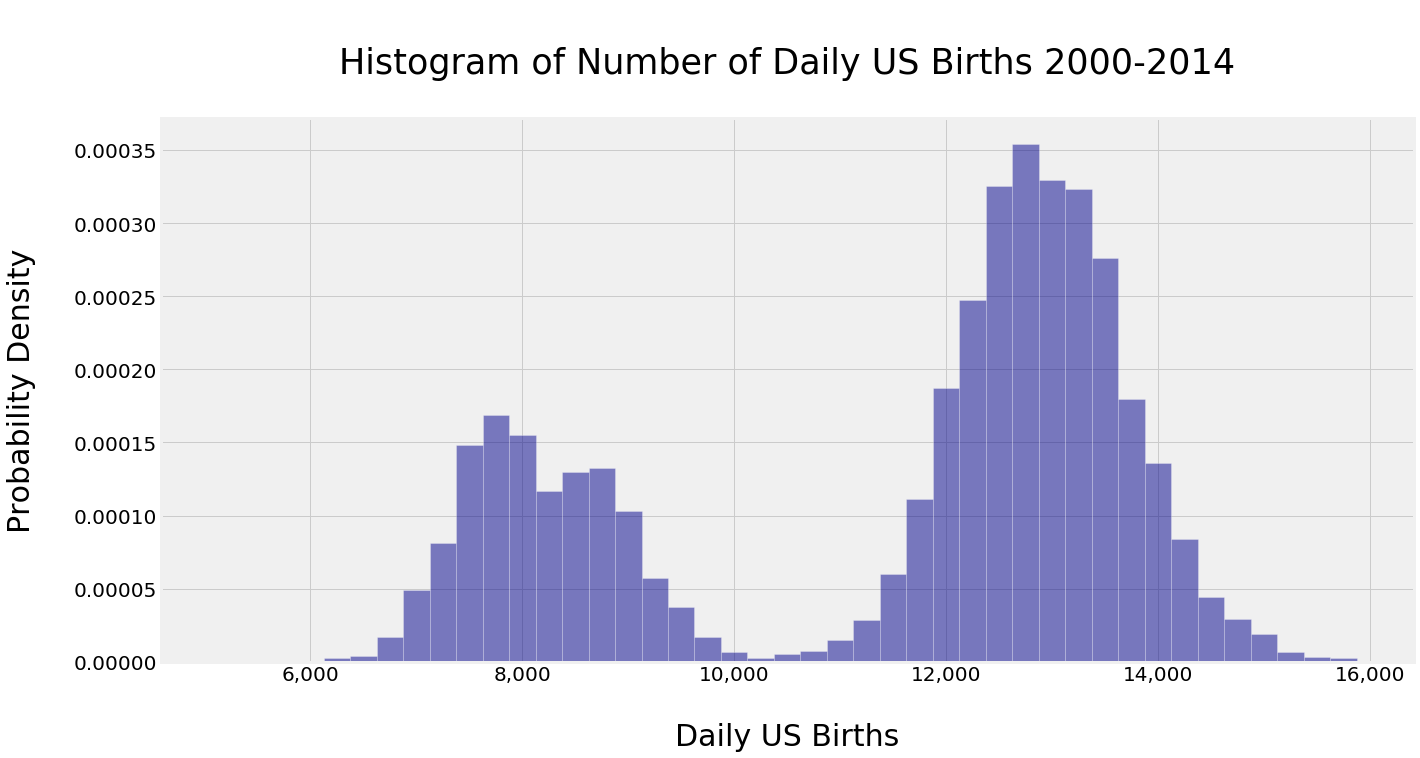

In [3]:
ax = data.births.plot(
    kind="hist",
    align="right",
    alpha=0.5,
    bins=np.arange(5000, 16000, 250),
    color="darkblue",
    density=True,
    edgecolor="white",
    figsize=(20, 10),
    fontsize=20,
)
ax.set_title("\nHistogram of Number of Daily US Births 2000-2014\n", size=35)
ax.set_xlabel("\nDaily US Births", size=30)
ax.set_xticklabels([f"{x:,.0f}" for x in ax.get_xticks()])
ax.set_ylabel("Probability Density\n", size=30);


### Group by year and plot the mean number of daily US births.  Note the reduction in daily births coinciding with the Great Recession.

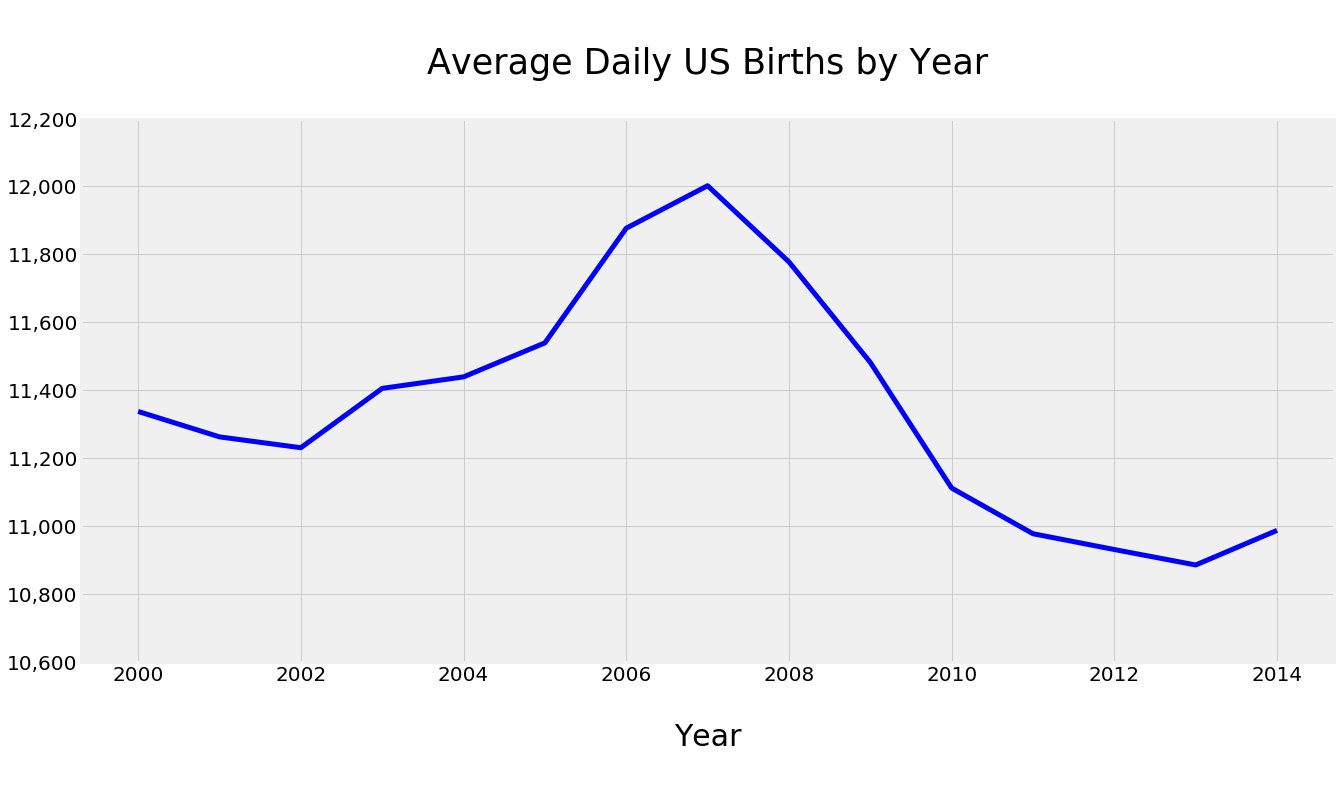

In [4]:
by_year = data.groupby("year").mean().births
ax = by_year.plot(
    kind="line",
    color="blue",
    linewidth=5,
    figsize=(20, 10),
    fontsize=20,
    ylim=(10600, 12200),
)
ax.set_title("\nAverage Daily US Births by Year\n", size=35)
ax.set_xlabel("\nYear\n", size=30)
ax.set_yticklabels([f"{y:,.0f}" for y in ax.get_yticks()]);


### Group by day of the week and plot the mean number of daily US births.  Recalling the earlier histogram, it is clear there are significantly fewer births on the weekends than on weekdays.

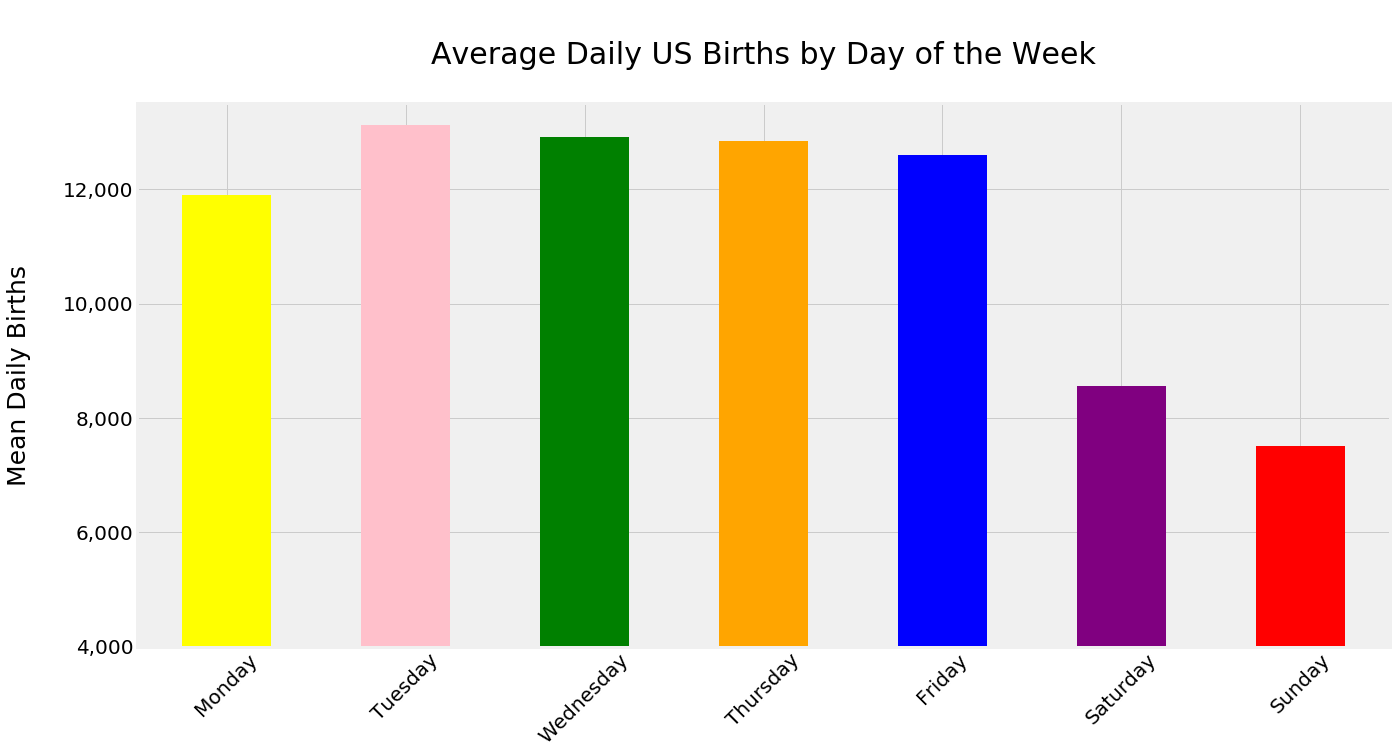

In [5]:
by_day_of_week = data.groupby("day_of_week").mean().births
by_day_of_week.index = calendar.day_name
ax = by_day_of_week.plot(
    kind="bar",
    color=["yellow", "pink", "green", "orange", "blue", "purple", "red"],
    figsize=(20, 10),
    fontsize=20,
    rot=45,
    ylim=(4000, 13500),
)
ax.set_title("\nAverage Daily US Births by Day of the Week\n", size=30)
ax.set_ylabel("Mean Daily Births\n", size=25)
ax.set_yticklabels([f"{y:,.0f}" for y in ax.get_yticks()]);


### Group by month and plot the mean number of daily US births.

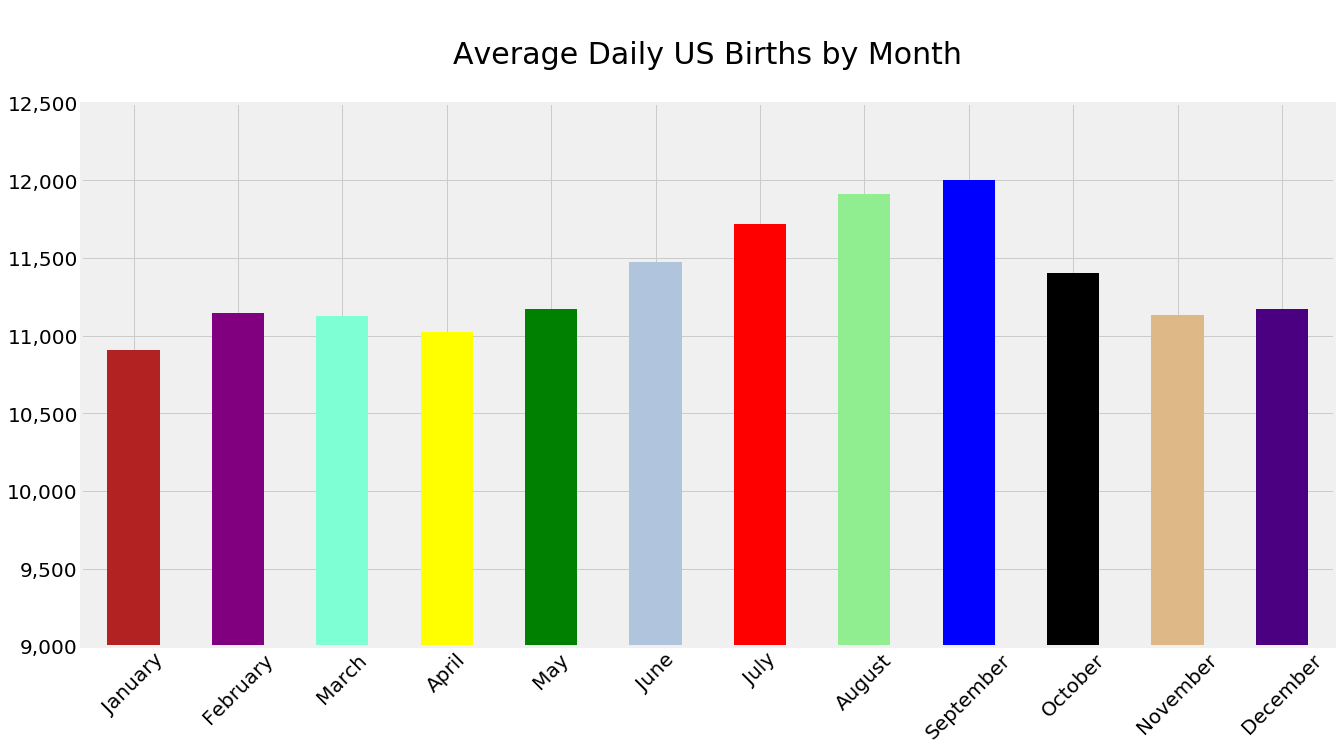

In [6]:
by_month = data.groupby("month").mean().births
by_month.index = calendar.month_name[1:]
ax = by_month.plot(
    kind="bar",
    color=[
        "firebrick",
        "purple",
        "aquamarine",
        "yellow",
        "green",
        "lightsteelblue",
        "red",
        "lightgreen",
        "blue",
        "black",
        "burlywood",
        "indigo",
    ],
    figsize=(20, 10),
    fontsize=20,
    rot=45,
    ylim=(9000, 12500),
)
ax.set_title("\nAverage Daily US Births by Month\n", size=30)
ax.set_yticklabels([f"{y:,.0f}" for y in ax.get_yticks()]);


### Group by month and date of the month and plot the number of mean daily births.  Note the sawtooth pattern due to fluctuations in the number of weekend days that fall on certain days of the month for the years 2000-2014.

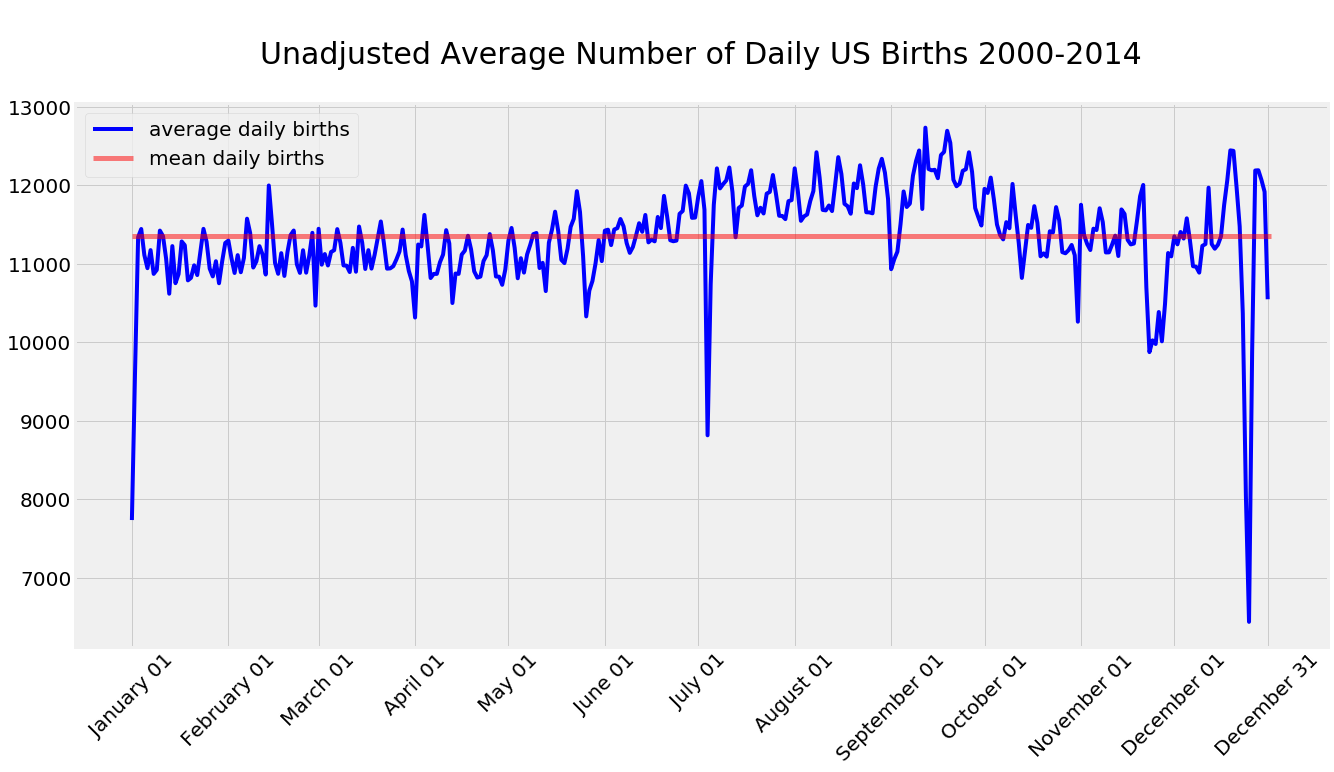

In [7]:
mean = data.births.mean()
by_month_and_date = data.groupby(["month", "date_of_month"]).births.mean()
dates = pd.date_range("1/1/2000", "12/31/2000", freq="MS").append(
    pd.DatetimeIndex(["12/31/2000"])
)
ax1 = by_month_and_date.plot(
    kind="line",
    color="blue",
    figsize=(20, 10),
    fontsize=20,
    label="average daily births",
    rot=45,
)
ax2 = plt.plot(
    [0, 366],
    [mean, mean],
    alpha=0.5,
    color="red",
    label="mean daily births",
    linewidth=5,
)
ax1.set_title("\nUnadjusted Average Number of Daily US Births 2000-2014\n", size=30)
ax1.set_xlabel("")
ax1.legend(fontsize=20)
plt.xticks(dates.dayofyear - 1, dates.strftime("%B %d"))
ax.set_yticklabels([f"{x:,.0f}" for x in ax.get_yticks()]);


### Create a dataframe (mean_births_by_month_and_dow) that contains the daily average number of US births from 2000-2014 by month and day of the week.  We will use this dataframe to normalize daily births by the month and day of the week.

In [8]:
mean_births_by_month_and_dow = (
    data.groupby(by=["month", "day_of_week"])
    .births.mean()
    .reset_index()
    .rename(columns={"births": "mean_births"})
)
mean_births_by_month_and_dow.head()


,month,day_of_week,mean_births
0,1,1,11322.656716
1,1,2,12384.492537
2,1,3,12266.253731
3,1,4,12398.985075
4,1,5,12291.738462


### Merge mean_births_by_month_and_dow with the the original dataframe.

In [9]:
data = data.merge(
    mean_births_by_month_and_dow, on=["month", "day_of_week"]
).sort_values(by=["year", "month", "date_of_month"])
data.head()


,year,month,date_of_month,day_of_week,births,mean_births
0,2000,1,1,6,9083,8332.515152
66,2000,1,2,7,8006,7314.075758
132,2000,1,3,1,11363,11322.656716
199,2000,1,4,2,13032,12384.492537
266,2000,1,5,3,12558,12266.253731


### Add the column deviation_from_average (births / mean_births - 1).

In [10]:
data["deviation_from_avg"] = data.births / data.mean_births - 1
data.reset_index(inplace=True, drop=True)
data.head()


,year,month,date_of_month,day_of_week,births,mean_births,deviation_from_avg
0,2000,1,1,6,9083,8332.515152,0.090067
1,2000,1,2,7,8006,7314.075758,0.094602
2,2000,1,3,1,11363,11322.656716,0.003563
3,2000,1,4,2,13032,12384.492537,0.052284
4,2000,1,5,3,12558,12266.253731,0.023784


### Create the data_to_plot Series in which the mean deviation_from_avg is grouped by the month and date_of_month.

In [11]:
data_to_plot = (
    data.groupby(by=["month", "date_of_month"])
    .deviation_from_avg.mean()
    .reset_index()
).deviation_from_avg
data_to_plot.head()

0   -0.253503
1   -0.115616
2    0.004572
3    0.031172
4    0.035743
Name: deviation_from_avg, dtype: float64

### Create a dictionary of significant dates in a (leap year) calendar year using the pandas.Timestamp function (1 is subtracted from each value to make the day of the year zero based with Jan 1 = 0). 

In [12]:
significant_dates = {
    "New Year's Day": pd.Timestamp("1/1/2000").dayofyear - 1,
    "Valentine's Day": pd.Timestamp("2/14/2000").dayofyear - 1,
    "Feb 29th": pd.Timestamp("2/29/2000").dayofyear - 1,
    "Apr 1st": pd.Timestamp("4/1/2000").dayofyear - 1,
    "Memorial Day": pd.Timestamp("5/26/2000").dayofyear - 1,
    "Jul 4th": pd.Timestamp("7/4/2000").dayofyear - 1,
    "Jul 7th": pd.Timestamp("7/7/2000").dayofyear - 1,
    "Labor Day": pd.Timestamp("9/3/2000").dayofyear - 1,
    "Halloween": pd.Timestamp("10/31/2000").dayofyear - 1,
    "Thanksgiving": pd.Timestamp("11/27/2000").dayofyear - 1,
    "Christmas": pd.Timestamp("12/25/2000").dayofyear - 1,
    "Dec 28th": pd.Timestamp("12/28/2000").dayofyear - 1,
}


### Plot the deviation of daily US births from the mean value of births for the corresponding month and day of the week.  Note the significant fall and rise for particular dates and holidays.

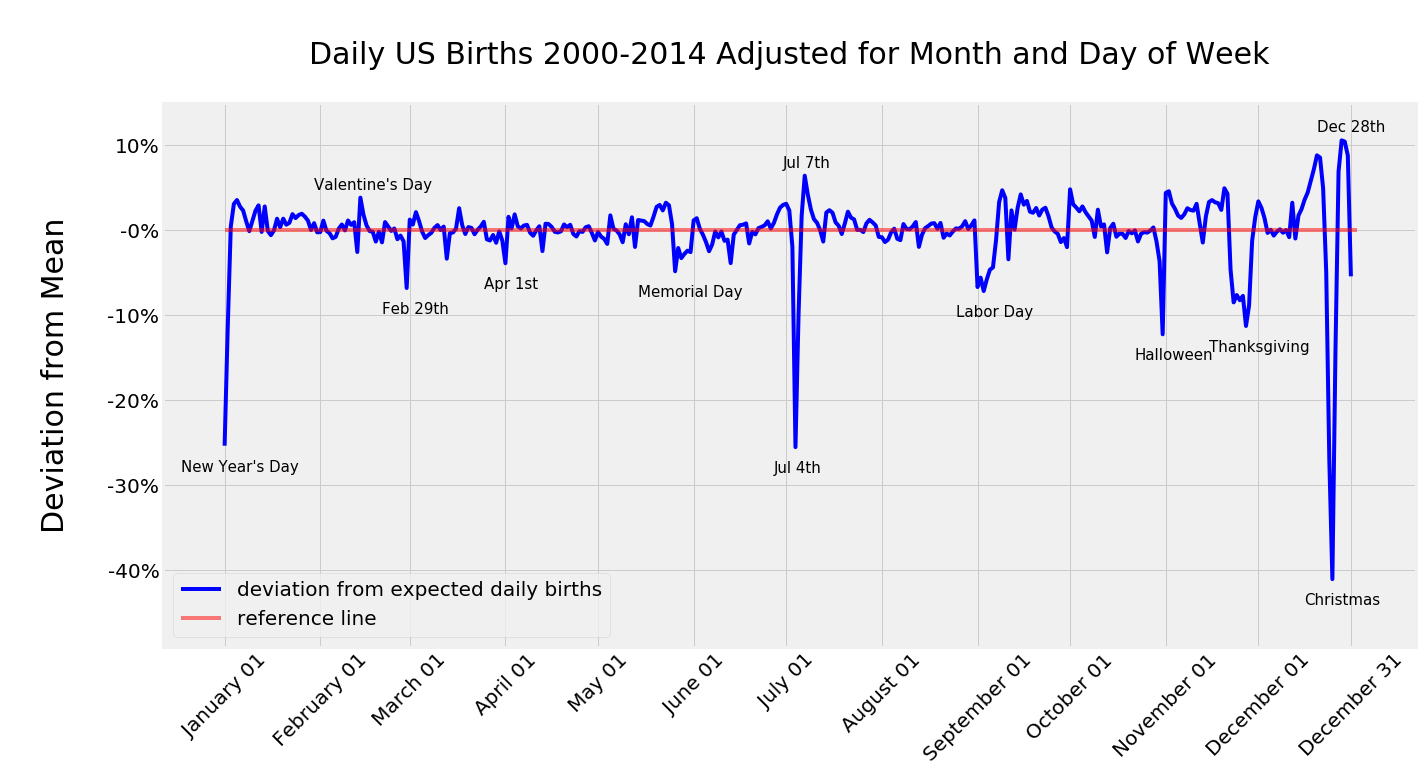

In [13]:
dates = pd.date_range("1/1/2000", "12/31/2000", freq="MS").append(
    pd.DatetimeIndex(["12/31/2000"])
)
ax = data_to_plot.plot(
    figsize=(20, 10),
    fontsize=20,
    rot=45,
    label="deviation from expected daily births",
    xlim=(-20, 386),
    ylim=(-0.49, 0.15),
    color="blue",
)
ax.plot([0, 367], [0, 0], color="red", alpha=0.5, label="reference line")
ax.set_title(
    (
        "\nDaily US Births 2000-2014 Adjusted for Month and Day of Week\n"
    ),
    size=30,
)
ax.set_ylabel("\nDeviation from Mean\n", size=30)
plt.xticks(dates.dayofyear - 1, dates.strftime("%B %d"))
ax.set_yticklabels([f"{num * 100:.0f}%" for num in np.arange(-0.5, 0.2, 0.1)])

for date in significant_dates:
    x = significant_dates[date] - len(date)  # shift the x coordinate of the label
    y = data_to_plot[significant_dates[date]]
    y += 0.01 if y > 0 else -0.03  # print the label above the point if it is positive
    ax.annotate(date, xy=(x, y), size=15)

ax.legend(fontsize=20, loc="lower left");


### While not specifically called out on the graph above, there appears to by a small cyclical decrease in births that occurs shortly before most months' midpoints.  Let's explore this a bit more.

In [14]:
data_for_the_13th = data[data.date_of_month == 13]
mean_births_13th = int(round(data_for_the_13th.births.mean()))
mean_births = int(round(data.births.mean()))
print(
    f"The number of mean daily US births is {mean_births:,}.  For the 13th "
    f"day of each month,\nthe mean is {mean_births_13th:,}"
)


The number of mean daily US births is 11,350.  For the 13th day of each month,
the mean is 11,111


### This number is lower for Fridays that fall on the 13th than for other Fridays.

In [15]:
friday_13th = data_for_the_13th[data_for_the_13th.day_of_week == 5]
fridays_not_13th = data[(data.day_of_week == 5) & (data.date_of_month != 13)]
mean_births_friday_13th = int(round(friday_13th.births.mean()))
mean_births_friday_not_13th = int(round(fridays_not_13th.births.mean()))
mean_births_friday_13th, mean_births_friday_not_13th
print(
    f"The number of mean daily US births is {mean_births_friday_13th:,} on Fridays "
    f"that fall on the 13th.\nOn Fridays that do not fall on the 13th it is "
    f"{mean_births_friday_not_13th:,}."
)

The number of mean daily US births is 11,950 on Fridays that fall on the 13th.
On Fridays that do not fall on the 13th it is 12,618.


### Plot a histogram of the number of daily US births on Fridays.  Note that the mean number of births that fall on the 13th of the month is less than the mean of all Friday births.

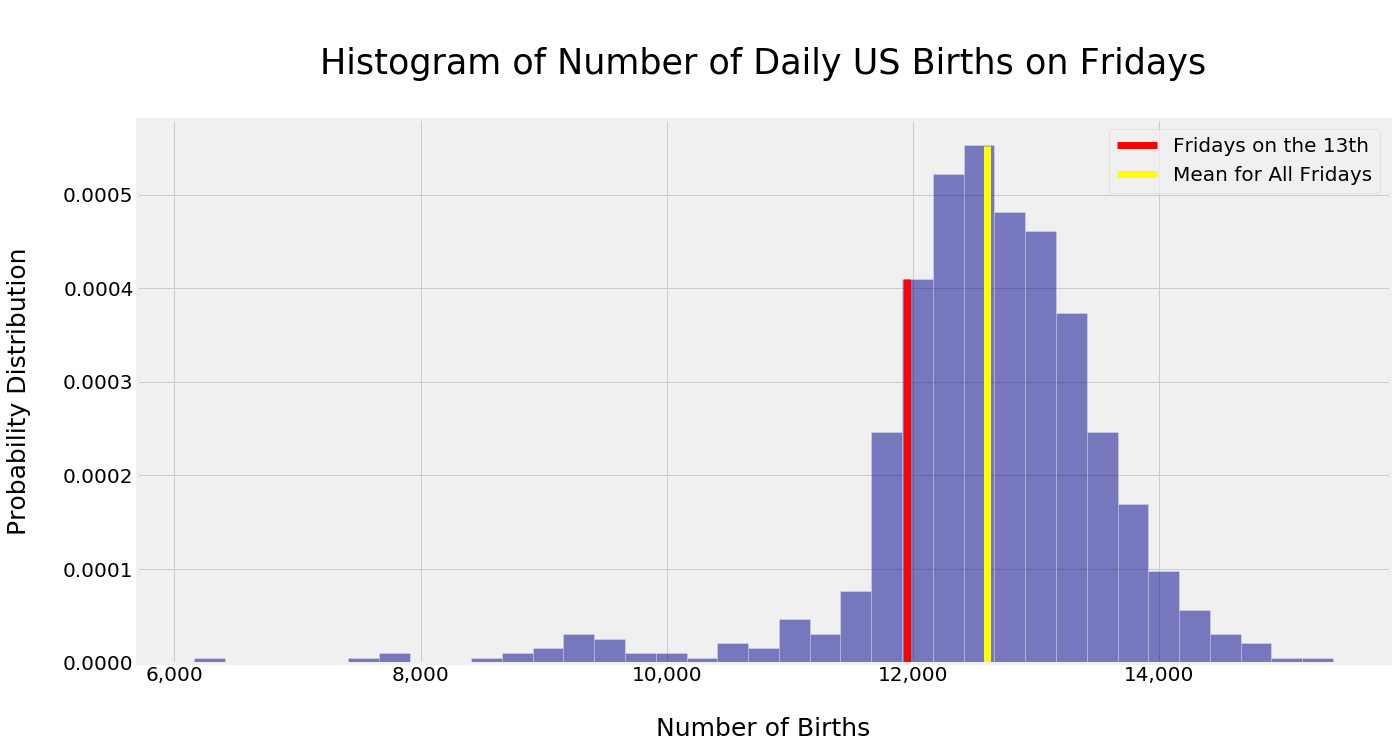

In [16]:
fridays = data[data.day_of_week == 5]
low = fridays.births.min()
high = fridays.births.max()
ax = fridays.births.hist(
    alpha=0.5,
    bins=np.arange(low, high, 250),
    color="darkblue",
    density=True,
    edgecolor="white",
    figsize=(20, 10),
)
ax.tick_params(labelsize=20)
ax.plot(
    [mean_births_friday_13th, mean_births_friday_13th],
    [0, 0.00041],
    color="red",
    linewidth=7,
    label="Fridays on the 13th",
)
ax.plot(
    [fridays.births.mean(), fridays.births.mean()],
    [0, 0.000552],
    color="yellow",
    linewidth=7,
    label="Mean for All Fridays"
)
ax.legend(fontsize=20)
ax.set_title("\nHistogram of Number of Daily US Births on Fridays\n", size=35)
ax.set_xlabel("\nNumber of Births", size=25)
ax.set_xticklabels([f"{x:,.0f}" for x in ax.get_xticks()])
ax.set_ylabel("Probability Distribution\n", size=25);


### The mean number of births on Fridays that fall on the 13th of the month represent the 15.7th percentile for all Friday births.

In [17]:
percentile_for_13th = np.round(
    stats.percentileofscore(fridays.births, friday_13th.births.mean()), 1
)
print(
    f"The mean number of births on Fridays that fall on the 13th of the month "
    f"represent the {percentile_for_13th}th\npercentile for all Friday births."
)


The mean number of births on Fridays that fall on the 13th of the month represent the 15.7th
percentile for all Friday births.
